Solubility prediction using GraphConvolution from Deepchem (https://github.com/deepchem)
------ Gashaw M. Goshu 9/20/2020 -------

In [1]:
import numpy as np
from deepchem.models import GraphConvModel
import tensorflow as tf
import deepchem
from deepchem.molnet import load_delaney
import sklearn
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
dataset_file ='delaney-processed.csv'

In [3]:
#dataset_file ='Orbital_Energies_input_data-Copy1.xlsx'
delaney_tasks = ['measured log solubility in mols per litre']
featurizer = deepchem.feat.ConvMolFeaturizer()

In [4]:
loader = deepchem.data.CSVLoader(tasks=delaney_tasks, feature_field="smiles", featurizer=featurizer)

dataset = loader.featurize(dataset_file, shard_size=8192)

# Initialize transformers
transformers = [
deepchem.trans.NormalizationTransformer(
  transform_y=True, dataset=dataset)
]

print("About to transform data")
for transformer in transformers:
    dataset = transformer.transform(dataset)
#train_dataset, valid_dataset, test_dataset = delaney_datasets
splitter = deepchem.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset,frac_test=0.3,frac_train=0.6,frac_valid=0.1)

C:\Users\Gashaw\AppData\Roaming\Python\Python38\site-packages\deepchem\data\data_loader.py:160: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  warnings.warn(


About to transform data


In [5]:
# Fit models
metric = deepchem.metrics.Metric(deepchem.metrics.pearson_r2_score, np.mean)
# Do setup required for tf/keras models
# Number of features on conv-mols
n_feat = 75
# Batch size of models
batch_size = 128
model = GraphConvModel(
    len(delaney_tasks), batch_size=batch_size, mode='regression')

# Fit trained model
model.fit(train_dataset, nb_epoch=80)



C:\Users\Gashaw\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


0.027224710583686827

In [6]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
#test_scores = model.evaluate(test_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)



Evaluating model
Train scores
{'mean-pearson_r2_score': 0.9725700497475677}
Validation scores
{'mean-pearson_r2_score': 0.5836586493037176}


In [7]:
predicted_test = model.predict(test_dataset)
predicted_test.size

339

In [8]:
true_test = test_dataset.y
true_test.size

339

In [9]:
# Model accuracy using root mean square error 
rmse = np.sqrt(mean_squared_error(true_test, predicted_test)) 
print('rmse:', rmse)

rmse: 0.5615433055672928


In [10]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(true_test, predicted_test)
print('R2:', R2)

R2: 0.6935548376103402


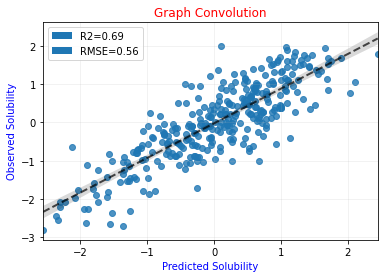

In [11]:
import matplotlib.patches as mpatches
sn.regplot(x=predicted_test, y=true_test, line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Solubility', color='blue')
plt.ylabel('Observed Solubility', color ='blue')
plt.title("Graph Convolution", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
plt.legend(handles=[R2,rmse])